In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [2]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 2 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [3]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [4]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [5]:
pick_frame_every_no = max_frame / 50 + 1

In [6]:
x = np.zeros([data_length, timesteps, dimensions])
y = np.zeros([data_length])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[2 * ((word_no * data_per_word) + data_no), curr_idx, :] = feature
            curr_idx += 1

        y[2 * ((word_no * data_per_word) + data_no)] = word_no
#         print((word_no * data_per_word * 2) + data_no)
        del_idx = range(0, len(json_data), pick_frame_every_no)
        json_data_speedup = np.delete(json_data, del_idx)
        
        curr_idx = 0
        
        for frame_no, frame in enumerate(json_data_speedup):
            if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
                continue
            feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
            x[(word_no * data_per_word * 2) + data_per_word + data_no, curr_idx, :] = feature
            curr_idx += 1

        y[(word_no * data_per_word * 2) + data_per_word + data_no] = word_no
#         print((word_no * data_per_word * 2) + 1 + data_no)
#         print('___')

In [7]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [8]:
x_train = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 / 3])
x_test = np.zeros([data_length / 3, timesteps, dimensions])
y_test = np.zeros([data_length / 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx / 3] = x_norm[idx]
        y_test[idx / 3] = y[idx]
    else:
        x_train[idx - idx / 3] = x_norm[idx]
        y_train[idx - idx / 3] = y[idx]

In [9]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 / 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 / 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [12]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [ ]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 684 samples, validate on 342 samples
Epoch 1/1000
684/684 [==============================] - 6s 8ms/step - loss: 2.9808 - acc: 0.0409 - val_loss: 2.9547 - val_acc: 0.0526
Epoch 2/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.9455 - acc: 0.0556 - val_loss: 2.9115 - val_acc: 0.0965
Epoch 3/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.8639 - acc: 0.0906 - val_loss: 2.7154 - val_acc: 0.1199
Epoch 4/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.7947 - acc: 0.1243 - val_loss: 2.7301 - val_acc: 0.0877
Epoch 5/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.7721 - acc: 0.1038 - val_loss: 2.4853 - val_acc: 0.1345
Epoch 6/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.6801 - acc: 0.0848 - val_loss: 2.4978 - val_acc: 0.1345
Epoch 7/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.6053 - acc: 0.1111 - val_loss: 2.4499 - val_acc: 0.1491
Epoch 8/1000
684

684/684 [==============================] - 4s 6ms/step - loss: 2.2154 - acc: 0.2368 - val_loss: 1.7980 - val_acc: 0.3772
Epoch 122/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.1552 - acc: 0.2456 - val_loss: 1.7997 - val_acc: 0.3626
Epoch 123/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.1497 - acc: 0.2368 - val_loss: 1.7887 - val_acc: 0.3977
Epoch 124/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.1385 - acc: 0.2705 - val_loss: 1.8048 - val_acc: 0.4415
Epoch 125/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.1350 - acc: 0.2895 - val_loss: 1.7752 - val_acc: 0.4415
Epoch 126/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.1192 - acc: 0.2734 - val_loss: 1.7935 - val_acc: 0.4211
Epoch 127/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.1607 - acc: 0.2617 - val_loss: 1.7850 - val_acc: 0.4123
Epoch 128/1000
684/684 [==============================] - 4s 5m

684/684 [==============================] - 4s 6ms/step - loss: 1.9053 - acc: 0.3406 - val_loss: 1.6274 - val_acc: 0.4678
Epoch 242/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.9623 - acc: 0.3377 - val_loss: 1.6121 - val_acc: 0.5000
Epoch 243/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.8570 - acc: 0.3465 - val_loss: 1.6014 - val_acc: 0.4971
Epoch 244/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.9599 - acc: 0.3143 - val_loss: 1.6152 - val_acc: 0.4942
Epoch 245/1000
684/684 [==============================] - 4s 6ms/step - loss: 2.0037 - acc: 0.3012 - val_loss: 1.6412 - val_acc: 0.4766
Epoch 246/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.9716 - acc: 0.3173 - val_loss: 1.6242 - val_acc: 0.4971
Epoch 247/1000
684/684 [==============================] - 4s 6ms/step - loss: 1.9040 - acc: 0.3289 - val_loss: 1.6334 - val_acc: 0.5058
Epoch 248/1000
684/684 [==============================] - 4s 6m

In [16]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

342/342 [==============================] - 0s 393us/step
('Test score:', 1.1305760681977746)
('Test accuracy:', 0.7543859645637155)


In [17]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

['acc', 'loss', 'val_acc', 'val_loss']


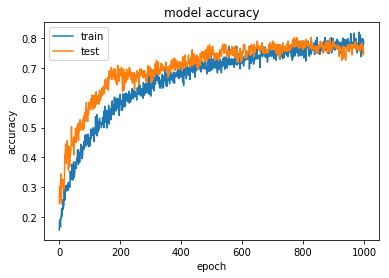

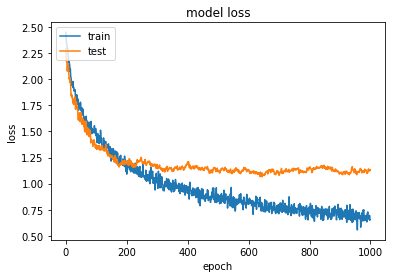

In [18]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()